In [ ]:
import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter # To print to tensorboard
#from model_utils import Discriminator, Generator # import models we've defined

# Define Discriminator and Generator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, im_dim, feature_dim):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
      # input_frame: 64x64
      nn.Conv2d(im_dim,feature_dim,kernel_size=4,stride=2,padding=1),    
      nn.LeakyReLU(0.2),
      # input_frame: 32x32
      nn.Conv2d(feature_dim,2*feature_dim,kernel_size=4,stride=2,padding=1),
      nn.BatchNorm2d(2*feature_dim),
      nn.LeakyReLU(0.2),
      # input_frame: 16x16
      nn.Conv2d(2*feature_dim,4*feature_dim,kernel_size=4,stride=2,padding=1),
      nn.BatchNorm2d(4*feature_dim),
      nn.LeakyReLU(0.2),
      # input_frame: 8x8
      nn.Conv2d(4*feature_dim,8*feature_dim,kernel_size=4,stride=2,padding=1),
      nn.BatchNorm2d(8*feature_dim),
      nn.LeakyReLU(0.2),
      # input_frame: 4x4

      nn.Conv2d(8*feature_dim,1,kernel_size=4,stride=2,padding=0),
      # input_frame: 1x1
      nn.Sigmoid()
    )
  def forward(self,x):
    return self.net(x)

In [ ]:
class Generator(nn.Module):
  def __init__(self, noise_dim, out_dim, feature_g):
    super(Generator,self).__init__()
    self.net = nn.Sequential(
      # input_frame: 1x1
      nn.ConvTranspose2d(noise_dim,feature_g*16, kernel_size=4, stride=1, padding=0),
      nn.BatchNorm2d(feature_g*16),
      nn.ReLU(),
      # input_frame: 4x4
      nn.ConvTranspose2d(feature_g*16,feature_g*8, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(feature_g*8),
      nn.ReLU(),
      # input_frame: 8x8
      nn.ConvTranspose2d(feature_g*8,feature_g*4, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(feature_g*4),
      nn.ReLU(),
      # input_frame: 16x16
      nn.ConvTranspose2d(feature_g*4,feature_g*2, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(feature_g*2),
      nn.ReLU(),
      # input_frame: 32x32

      nn.ConvTranspose2d(feature_g*2,out_dim, kernel_size=4, stride=2, padding=1),
      # input_frame: 64x64
      nn.Tanh()
    )
  def forward(self,x):
    return self.net(x)

# Hyperparameters

In [ ]:
lr = 0.0002
batch_size = 64
image_size = 64
img_dim = 1
noise_dim = 256
num_epochs = 10

feature_dim_d = 16
feature_dim_g = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get Data and transform it

In [ ]:
my_transforms = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

dataset = datasets.MNIST(root="dataset/", train=True, transform=my_transforms, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Make instances of DISCRIMINATOR and GENERATOR

In [ ]:
myDISC = Discriminator(img_dim,feature_dim_d).to(device)
myGEN = Generator(noise_dim,img_dim,feature_dim_g).to(device)

# Set Optimizers

In [ ]:
# We will define deparate optimizers for D and G
optimizerD = optim.Adam(myDISC.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(myGEN.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
criterion = nn.BCELoss()

# Create fixed noise

In [ ]:
fixed_noise = torch.randn(64, noise_dim, 1, 1).to(device)

# Train Networks

In [ ]:
# set the networks to training mode:
myDISC.train()
myGEN.train()

for epoch in range(num_epochs):
    for batch_idx, (act_ims, labels) in enumerate(dataloader):
        # actual bact to device
        act_ims = act_ims.to(device)
        batch_size = act_ims.shape[0]

        '''
        Step of Discriminator
        '''
        # clear D gradients
        myDISC.zero_grad()
        myGEN.zero_grad()
  
        # maximize log(D(x)) + log(1 - D(G(z)))  # real-ra 1-et, fake-re 0-t
        # D loss for real
        label = (torch.ones(batch_size) * 0.9).to(device) # 0.9-et allitsunk hogy igazi, azert nem 1-et mert nem akarunk teljes bizonyossagot beadni
        output = myDISC(act_ims).reshape(-1)
        lossD_real = criterion(output, label)
        D_x = output.mean().item()
        # Make a generation from noise
        noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
        fake = myGEN(noise)
        # D loss for fake
        label = (torch.ones(batch_size) * 0.1).to(device)
        output = myDISC(fake.detach()).reshape(-1) # 0.1-et allitsunk hogy fake, azert nem nullat mert nem akarunk teljes bizonyossagot beadni
        lossD_fake = criterion(output, label)

        # Sum losses
        lossD = lossD_real + lossD_fake
        lossD.backward() # Backpropagation
        optimizerD.step() # Step


        '''
        Step of Generator
        '''
        # maximize log(D(G(z)))
        label = torch.ones(batch_size).to(device)
        output = myDISC(fake).reshape(-1)
        lossG = criterion(output, label)
        lossG.backward()
        optimizerG.step()


        '''
        Print values
        '''
        # Print losses
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \Loss D: {lossD:.4f}, loss G: {lossG:.4f} D(x): {D_x:.4f}")


Epoch [0/10] Batch 0/938 \Loss D: 1.3132, loss G: 0.9144 D(x): 0.5861
Epoch [0/10] Batch 100/938 \Loss D: 0.6615, loss G: 2.9420 D(x): 0.8813
Epoch [0/10] Batch 200/938 \Loss D: 0.6958, loss G: 2.5464 D(x): 0.9350
Epoch [0/10] Batch 300/938 \Loss D: 0.8409, loss G: 1.3213 D(x): 0.6613
Epoch [0/10] Batch 400/938 \Loss D: 0.7612, loss G: 1.8361 D(x): 0.7926
Epoch [0/10] Batch 500/938 \Loss D: 0.8554, loss G: 1.9605 D(x): 0.7902
Epoch [0/10] Batch 600/938 \Loss D: 1.1176, loss G: 1.1762 D(x): 0.4726
Epoch [0/10] Batch 700/938 \Loss D: 0.7987, loss G: 1.4598 D(x): 0.7107
Epoch [0/10] Batch 800/938 \Loss D: 0.7983, loss G: 2.5557 D(x): 0.8771
Epoch [0/10] Batch 900/938 \Loss D: 0.7153, loss G: 2.0400 D(x): 0.7869
Epoch [1/10] Batch 0/938 \Loss D: 0.8014, loss G: 1.4574 D(x): 0.6870
Epoch [1/10] Batch 100/938 \Loss D: 0.7246, loss G: 1.6061 D(x): 0.7875
Epoch [1/10] Batch 200/938 \Loss D: 0.7483, loss G: 1.6002 D(x): 0.7538
Epoch [1/10] Batch 300/938 \Loss D: 0.7685, loss G: 1.8277 D(x): 0.7

In [ ]:
with torch.no_grad():
  fake = myGEN(fixed_noise)

  img_grid_real = torchvision.utils.make_grid(act_ims[:32], normalize=True)
  img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
  #writer_real.add_image("Mnist Real Images", img_grid_real)
  #writer_real.add_image("Mnist Fake Images", img_grid_fake)

In [ ]:
print(img_grid_real.shape)
print(img_grid_fake.shape)

torch.Size([3, 266, 530])
torch.Size([3, 266, 530])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

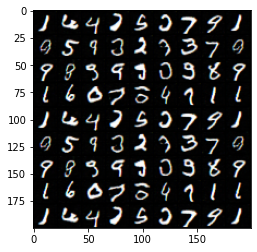

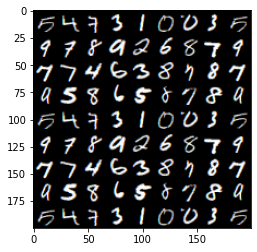

In [ ]:
img_grid_fake = np.reshape(img_grid_fake.cpu(), [266,530,3])
img_grid_real = np.reshape(img_grid_real.cpu(), [266,530,3])
plt.imshow(img_grid_fake[0:200,0:200,:])
plt.figure()
plt.imshow(img_grid_real[0:200,0:200,:])